# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v0-6a.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v0-6a'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path   label
0  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch
1  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch
2  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch
3  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch
4  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
2816  train/es\es_f_db16e\es_f_db16e__rmx__r48000__n...     spanish   
2478  train/pt\pt_m_81d30\pt_m_81d30__rmx__r48000__n...  portuguese   
1389  train/fr\fr_f_77c6a\fr_f_77c6a__rmx__r48000__n...      french   
1657  train/fr\fr_m_3c5d7\fr_m_3c5d7__rmx__r48000__n...      french   
847   train/en\en_f_9a47e\en_f_9a47e__rmx__r48000__n...     english   
1499  train/fr\fr_f_a99b5\fr_f_a99b5__rmx__r48000__n...      french   
1184  train/en\en_m_6a553\en_m_6a553__rmx__r48000__n...     english   
2999  train/es\es_m_60f8a\es_m_60f8a__rmx__r48000__n...     spanish   
3102  train/es\es_m_b5327\es_m_b5327__rmx__r48000__n...     spanish   
1918  train/fr\fr_m_b8307\fr_m_b8307__rmx__r48000__n...      french   
154   train/de\de_f_6cc5c\de_f_6cc5c__rmx__r48000__n...      deutch   
2782  train/es\es_f_cc86b\es_f_cc86b__rmx__r48000__n...     spanish   
2370  train/pt\pt_m_45107\pt_m_45107__rmx__r48000__n...  portuguese   
2032  train/pt\pt_f_52518\pt_f_52518__rmx__r48000__n...  portuguese   
2509  train/pt\pt_m_aa847\pt_m_aa847__rmx__r48000__n...  portuguese   
2943  train/es\es_m_4d7e5\es_m_4d7e5__rmx__r48000__n...     spanish   
1373  train/fr\fr_f_5bf8d\fr_f_5bf8d__rmx__r48000__n...      french   
1119  train/en\en_m_61764\en_m_61764__rmx__r48000__n...     english   
2061  train/pt\pt_f_5d3e4\pt_f_5d3e4__rmx__r48000__n...  portuguese   
641   train/de\de_m_fc6bd\de_m_fc6bd__rmx__r48000__n...      deutch   
2140  train/pt\pt_f_81c87\pt_f_81c87__rmx__r48000__n...  portuguese   
2730  train/es\es_f_7b894\es_f_7b894__rmx__r48000__n...     spanish   
2261  train/pt\pt_m_05e97\pt_m_05e97__rmx__r48000__n...  portuguese   
1817  train/fr\fr_m_90ed6\fr_m_90ed6__rmx__r48000__n...      french   
1592  train/fr\fr_f_e836d\fr_f_e836d__rmx__r48000__n...      french   
3049  train/es\es_m_7e1c8\es_m_7e1c8__rmx__r48000__n...     spanish   
2449  train/pt\pt_m_6e1fd\pt_m_6e1fd__rmx__r48000__n...  portuguese   
2624  train/es\es_f_47bd2\es_f_47bd2__rmx__r48000__n...     spanish   
2179  train/pt\pt_f_8a019\pt_f_8a019__rmx__r48000__n...  portuguese   
2088  train/pt\pt_f_6a030\pt_f_6a030__rmx__r48000__n...  portuguese   
2505  train/pt\pt_m_823cc\pt_m_823cc__rmx__r48000__n...  portuguese   
2784  train/es\es_f_cc86b\es_f_cc86b__rmx__r48000__n...     spanish   
3063  train/es\es_m_9d824\es_m_9d824__rmx__r48000__n...     spanish   
1274  train/en\en_m_f7d28\en_m_f7d28__rmx__r48000__n...     english   
438   train/de\de_m_50229\de_m_50229__rmx__r48000__n...      deutch   
1865  train/fr\fr_m_9a9f9\fr_m_9a9f9__rmx__r48000__n...      french   
889   train/en\en_f_c8835\en_f_c8835__rmx__r48000__n...     english   
2053  train/pt\pt_f_5d3e4\pt_f_5d3e4__rmx__r48000__n...  portuguese   
1743  train/fr\fr_m_545bf\fr_m_545bf__rmx__r48000__n...      french   
2511  train/pt\pt_m_aa847\pt_m_aa847__rmx__r48000__n...  portuguese   

      sample_rate                                        time_series  nframes  \
2816        48000  [-168, -22, 237, 503, 621, 494, 193, -99, -251...   240000   
2478        48000  [673, 681, 639, 554, 585, 864, 1065, 915, 679,...   240000   
1389        48000  [8, -5, -9, -3, 15, 39, 55, 48, 22, -16, -40, ...   240000   
1657        48000  [-2, -2, -2, -2, -2, -4, 0, 0, 1, 1, 1, 0, 0, ...   240000   
847         48000  [4205, 4200, 4167, 4156, 4221, 4355, 4472, 449...   240000   
1499        48000  [320, 248, 169, 126, 173, 310, 533, 807, 1095,...   240000   
1184        48000  [46, -131, -318, -451, -531, -611, -758, -955,...   240000   
2999        48000  [2963, 2820, 2674, 2550, 2453, 2372, 2291, 219...   240000   
3102        48000  [-49, -46, -41, -38, -32, -25, -19, -14, -10, ...   240000   
1918        48000  [-1169, -1169, -1208, -1312, -1491, -1700, -19...   240000   
154         48000  [573, 400, 170, -121, -467, -862, -1289, -1732...   240000   
2782        48000  [-3, 0, 0, 0, 0, 0, 0, 2, -3, 0, 0, 0, 0, 0, 0...   240000   
2370        48000  [1316, 1242, 1149, 1050, 972, 886, 850, 884, 8...   240000   


In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path   label  \
0  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch   
1  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch   
2  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch   
3  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch   
4  train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  de_f_0809f__rmx__r48000_           None           None      None     None   
1  de_f_0809f__rmx__r48000_           None           None      None     None   
2  de_f_0809f__rmx__r48000_           None           None      None     None   
3  de_f_0809f__rmx__r48000_           None           None      None     None   
4  de_f_0809f__rmx__r48000_           None           None      None     None   

   augmented_data  
0           False  
1           False  
2           False  
3           False  
4           False

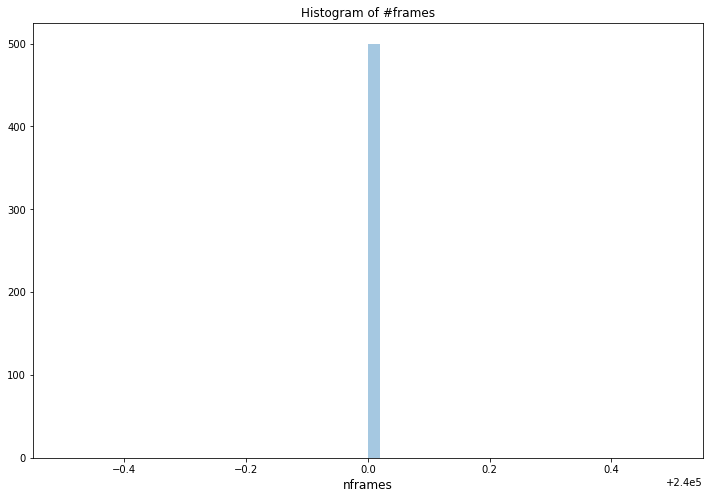

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

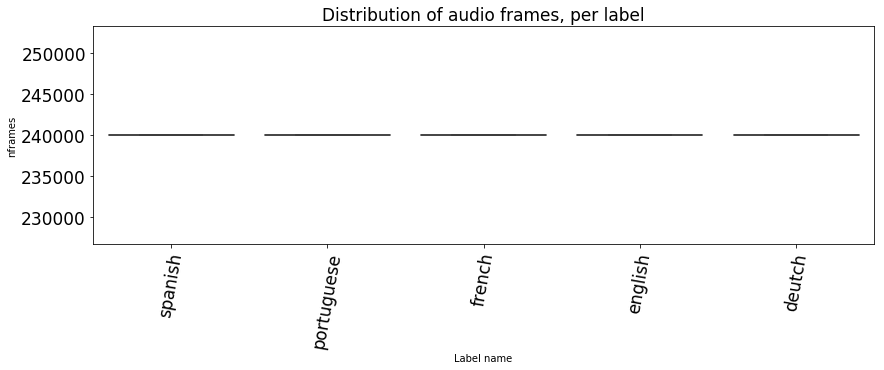

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path   label  \
0    train/de\de_f_0809f\de_f_0809f__rmx__r48000__n...  deutch   
425  train/de\de_m_4d099\de_m_4d099__rmx__r48000__n...  deutch   
426  train/de\de_m_4d099\de_m_4d099__rmx__r48000__n...  deutch   
427  train/de\de_m_4d099\de_m_4d099__rmx__r48000__n...  deutch   
428  train/de\de_m_4d099\de_m_4d099__rmx__r48000__n...  deutch   

                    file_name speed_changing pitch_changing noise_add  \
0    de_f_0809f__rmx__r48000_           None           None      None   
425  de_m_4d099__rmx__r48000_           None           None      None   
426  de_m_4d099__rmx__r48000_           None           None      None   
427  de_m_4d099__rmx__r48000_           None           None      None   
428  de_m_4d099__rmx__r48000_           None           None      None   

    low_pass  augmented_data  
0       None           False  
425     None           False  
426     None           False  
427     None           False  
428     None           False

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

643

Total number of labels in training data :  5
Labels are :  ['deutch' 'english' 'french' 'portuguese' 'spanish']


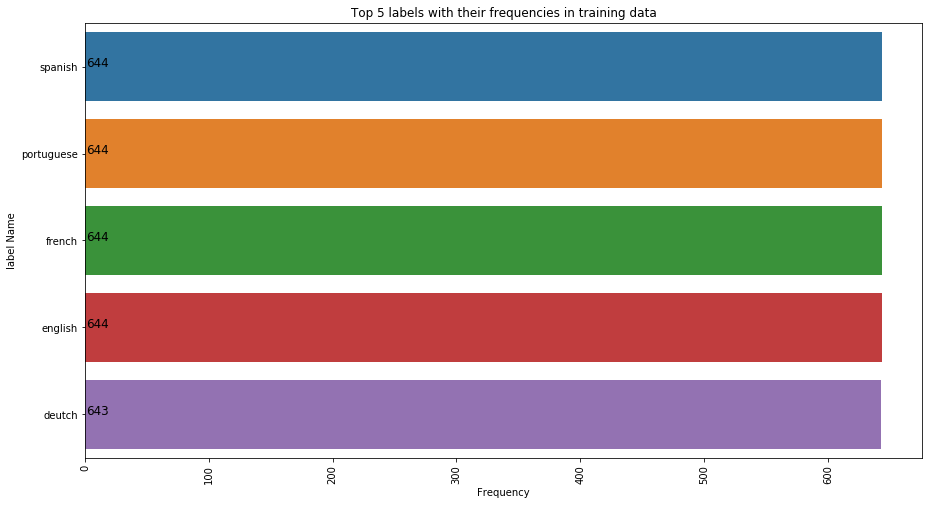

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0      deutch                28
1     english                28
2      french                28
3  portuguese                28
4     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label  file_name                      
deutch de_f_0809f__rmx__r48000_     22
       de_f_1996a__rmx__r48000_     23
       de_f_26ddc__rmx__r48000_     23
       de_f_2825f__rmx__r48000_     23
       de_f_40479__rmx__r48000_     23

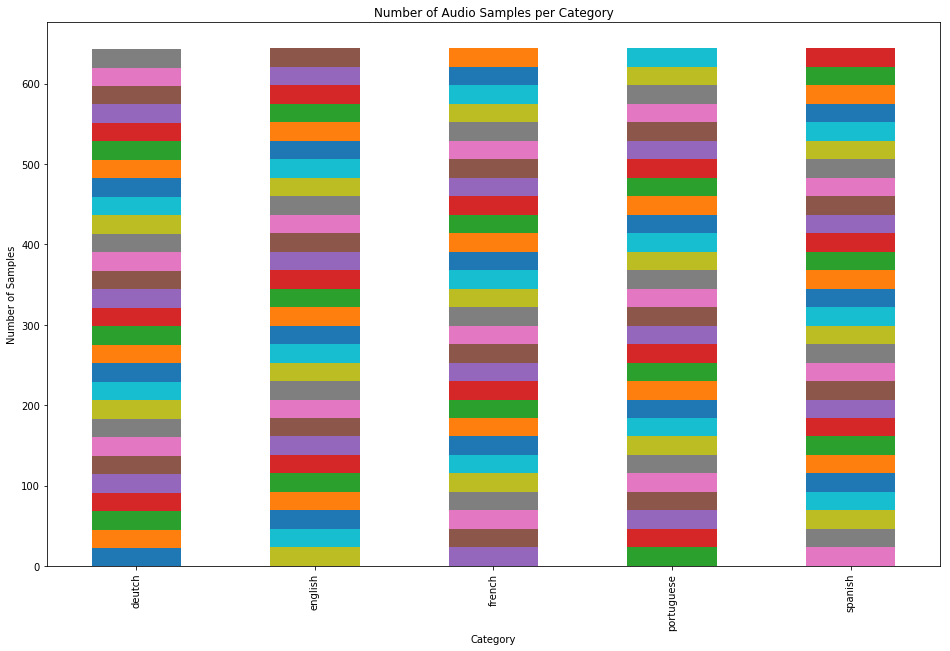

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
deutch     f         321
           m         322
english    f         322
           m         322
french     f         322
           m         322
portuguese f         299
           m         345
spanish    f         322
           m         322

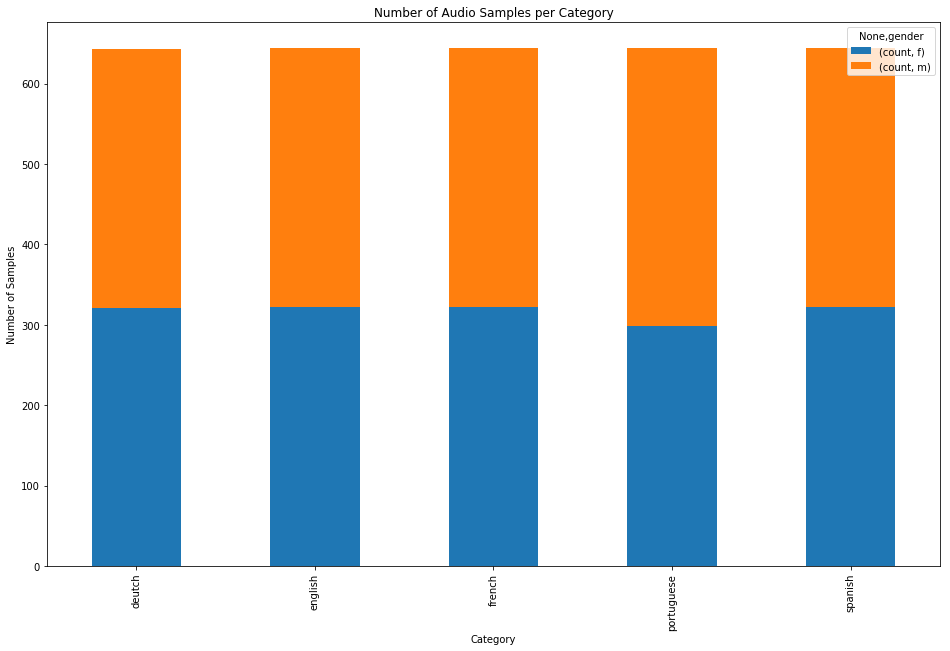

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
deutch     False             643
english    False             644
french     False             644
portuguese False             644
spanish    False             644

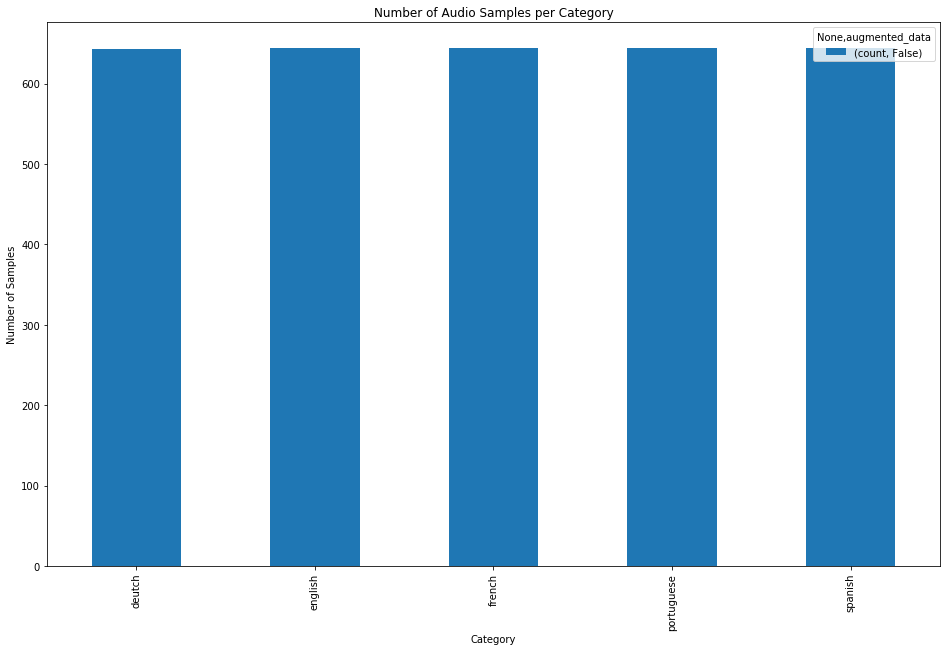

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label      augmented_data                                                     
deutch     False             643               0               0          0   
english    False             644               0               0          0   
french     False             644               0               0          0   
portuguese False             644               0               0          0   
spanish    False             644               0               0          0   

                           low_pass  
label      augmented_data            
deutch     False                  0  
english    False                  0  
french     False                  0  
portuguese False                  0  
spanish    False                  0

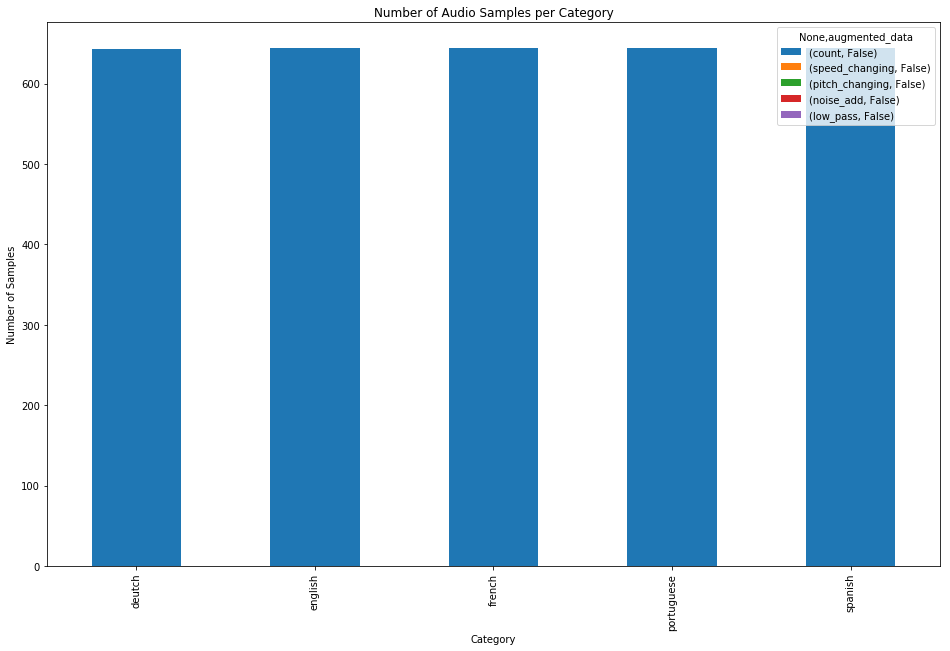

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

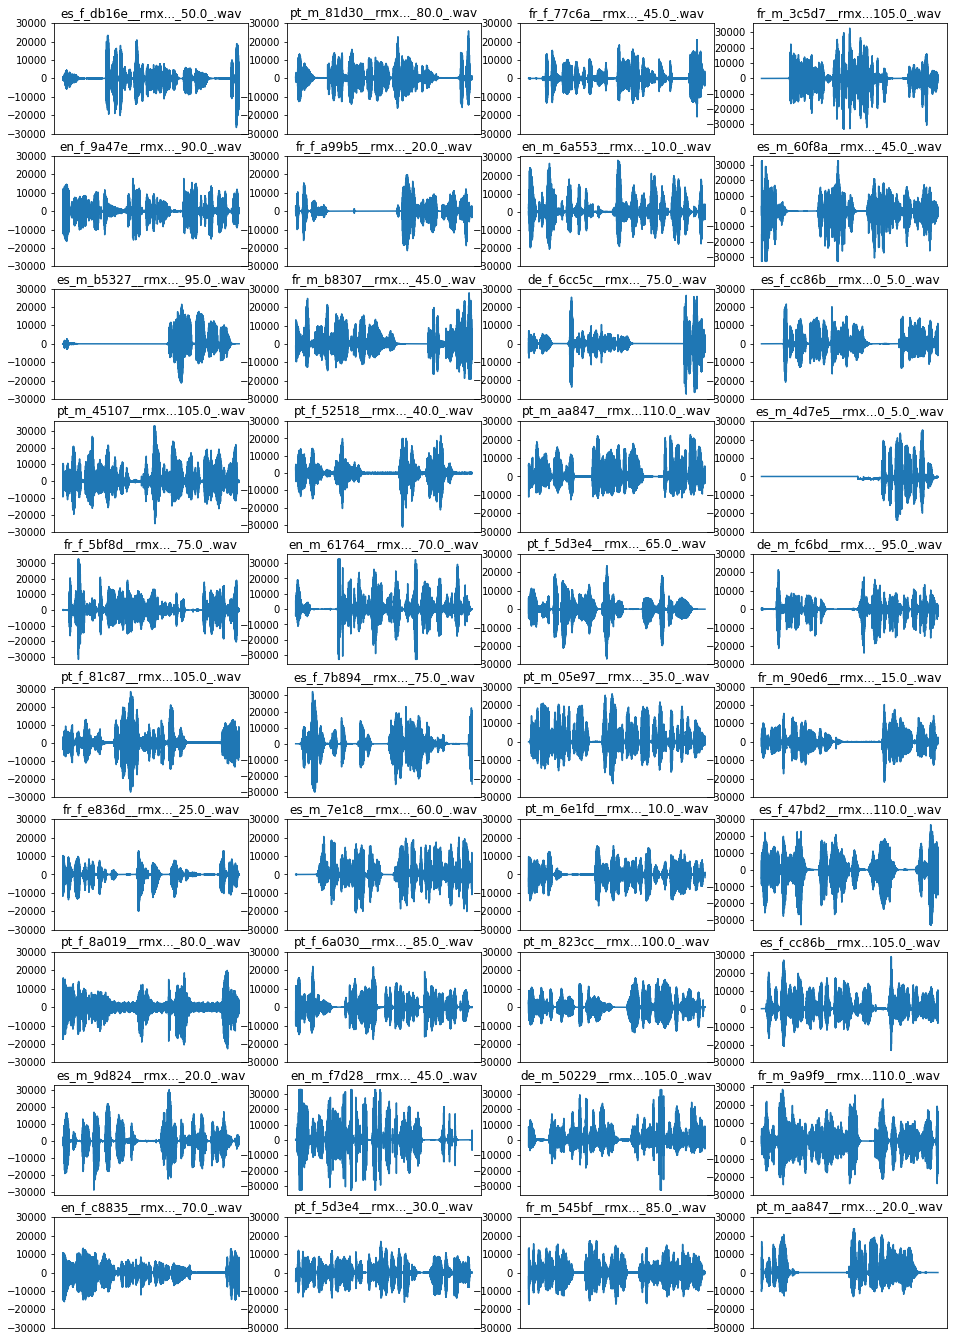

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
    ax[i//4, i%4].get_yaxis().set_ticks([-30000, -20000, -10000, 0, 10000, 20000, 30000])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

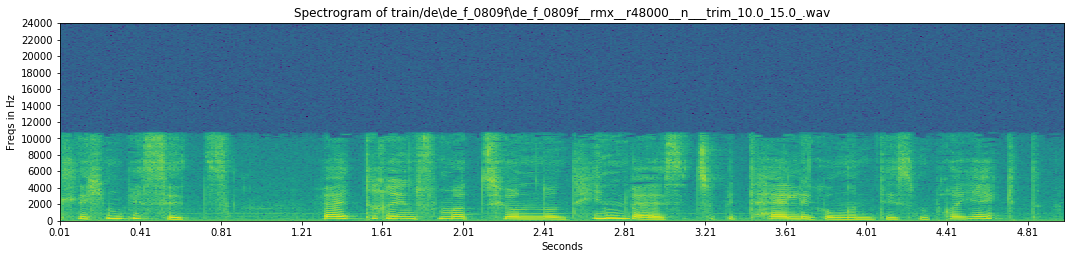

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (3219, 9)


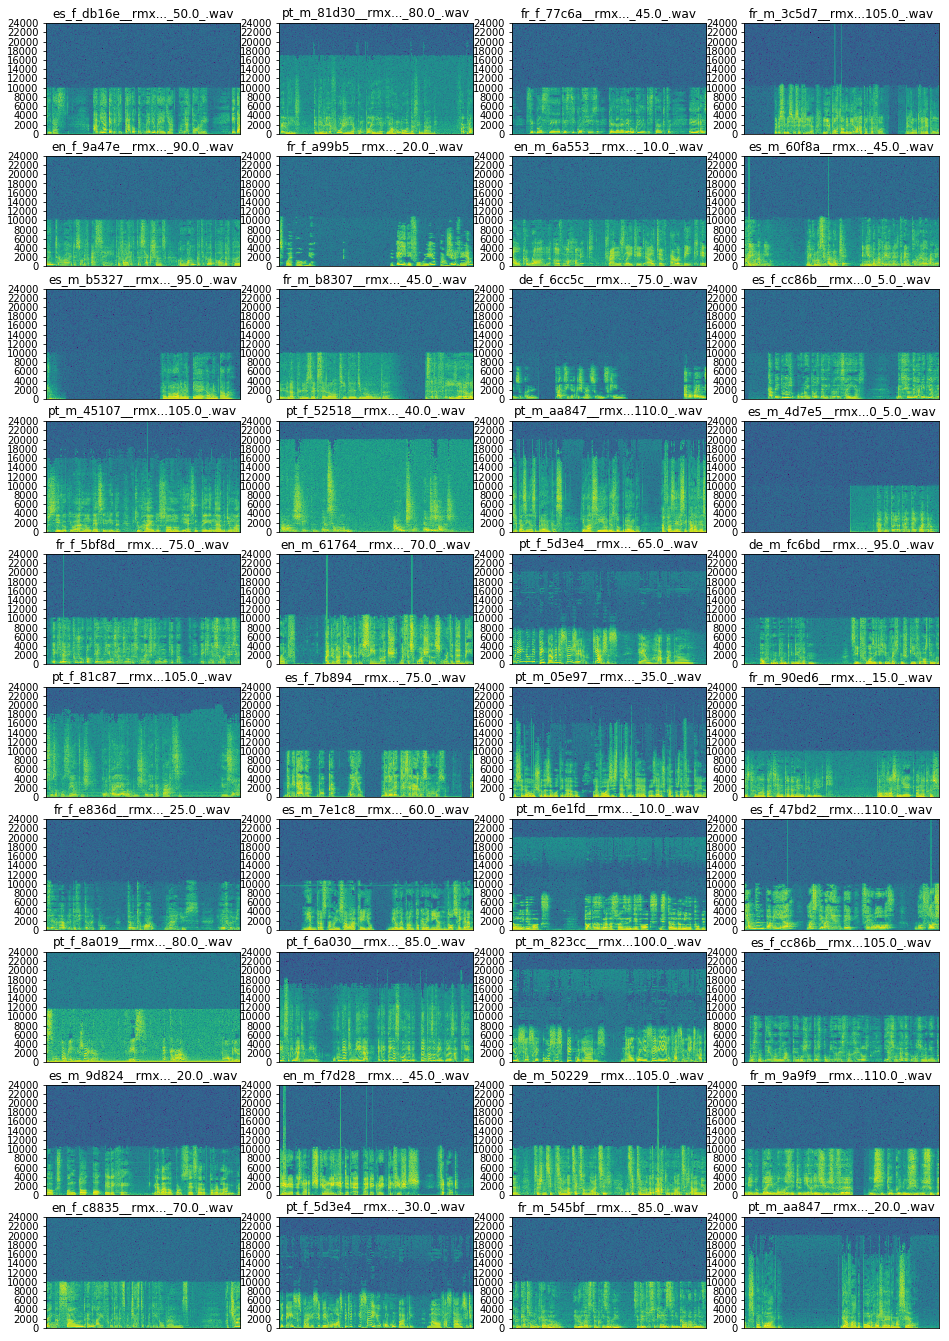

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

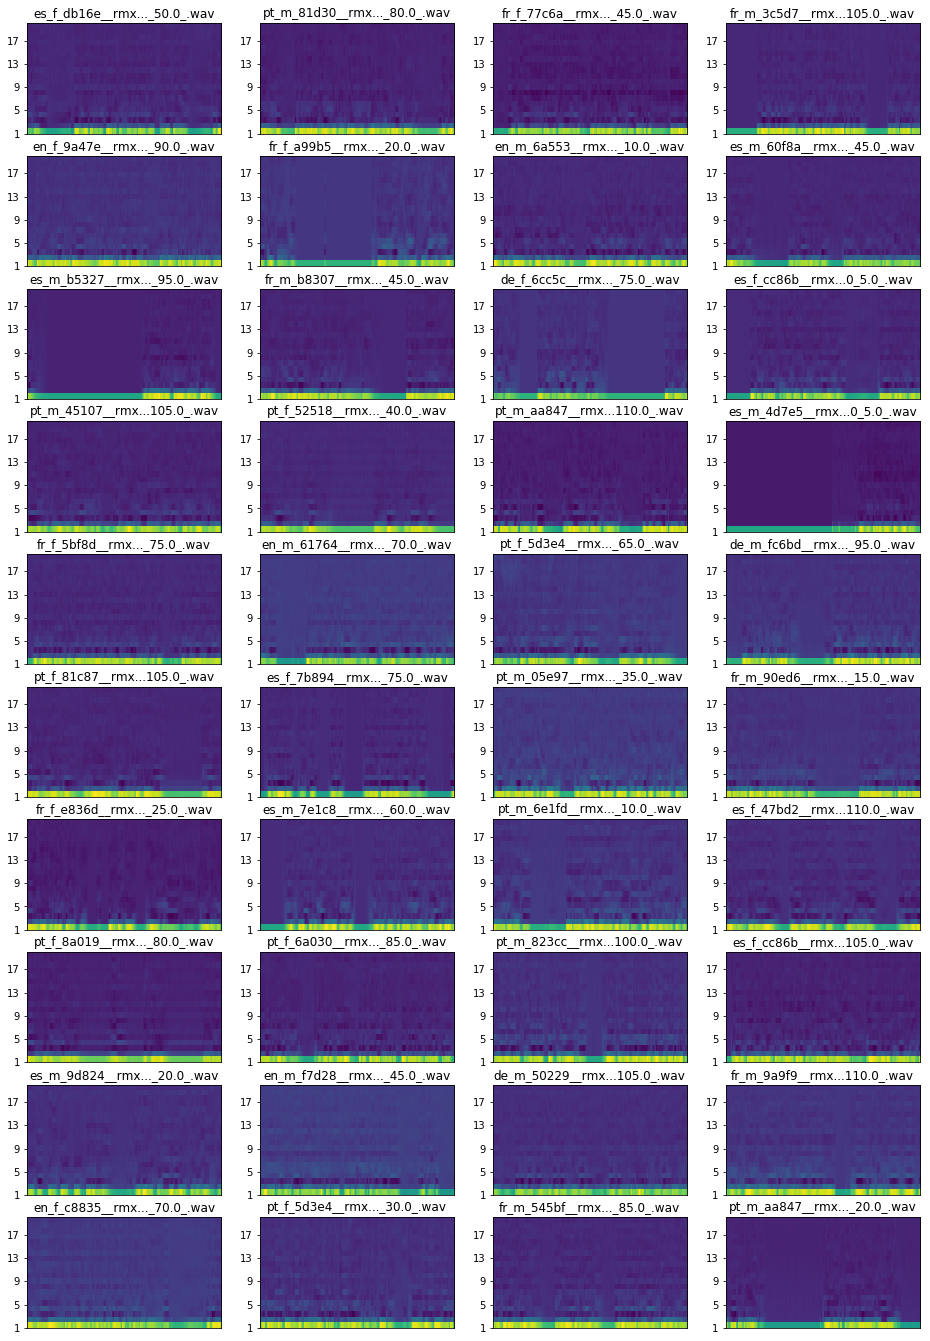

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

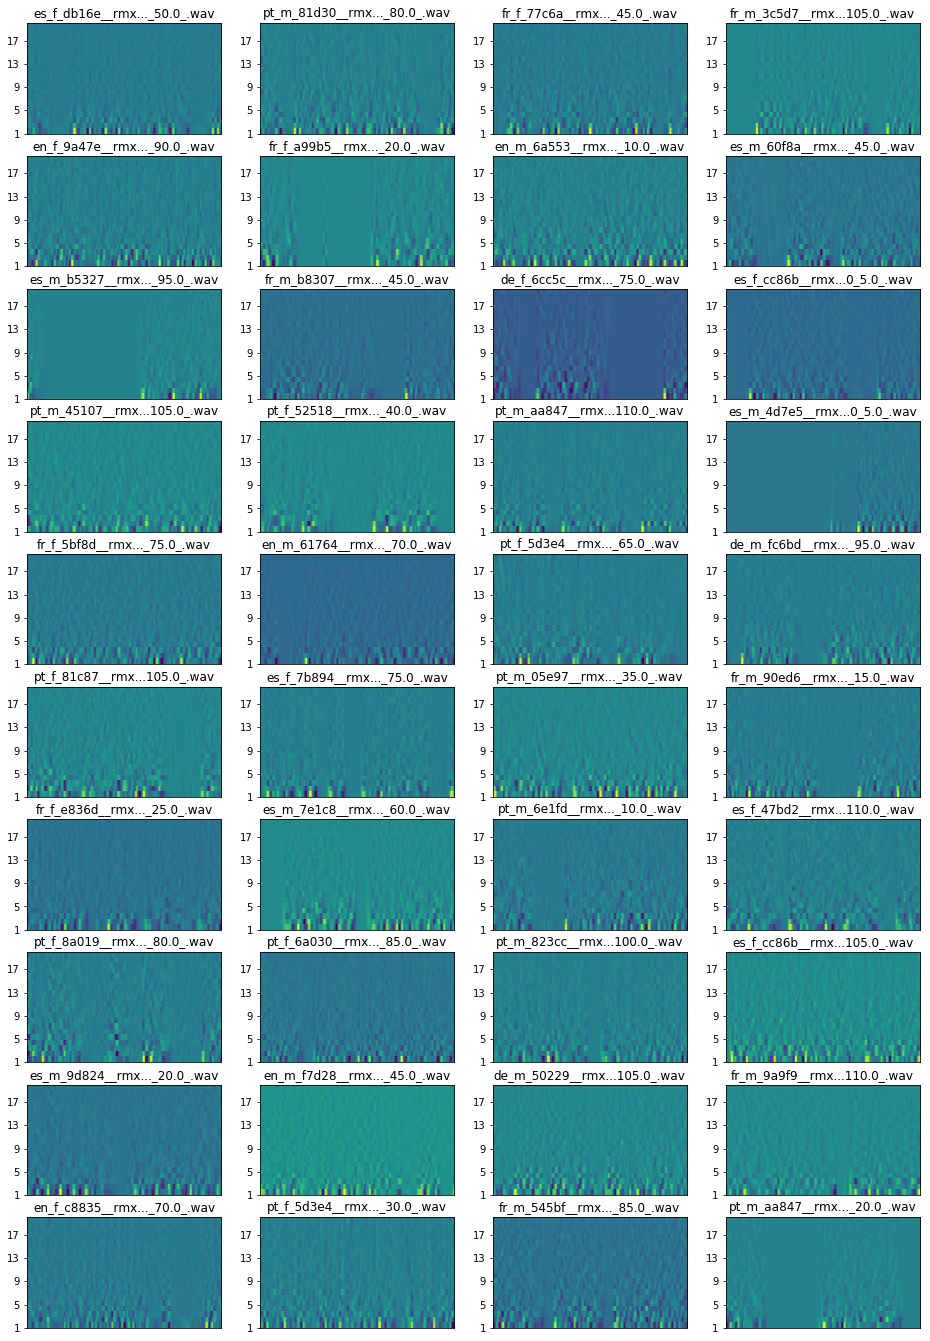

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

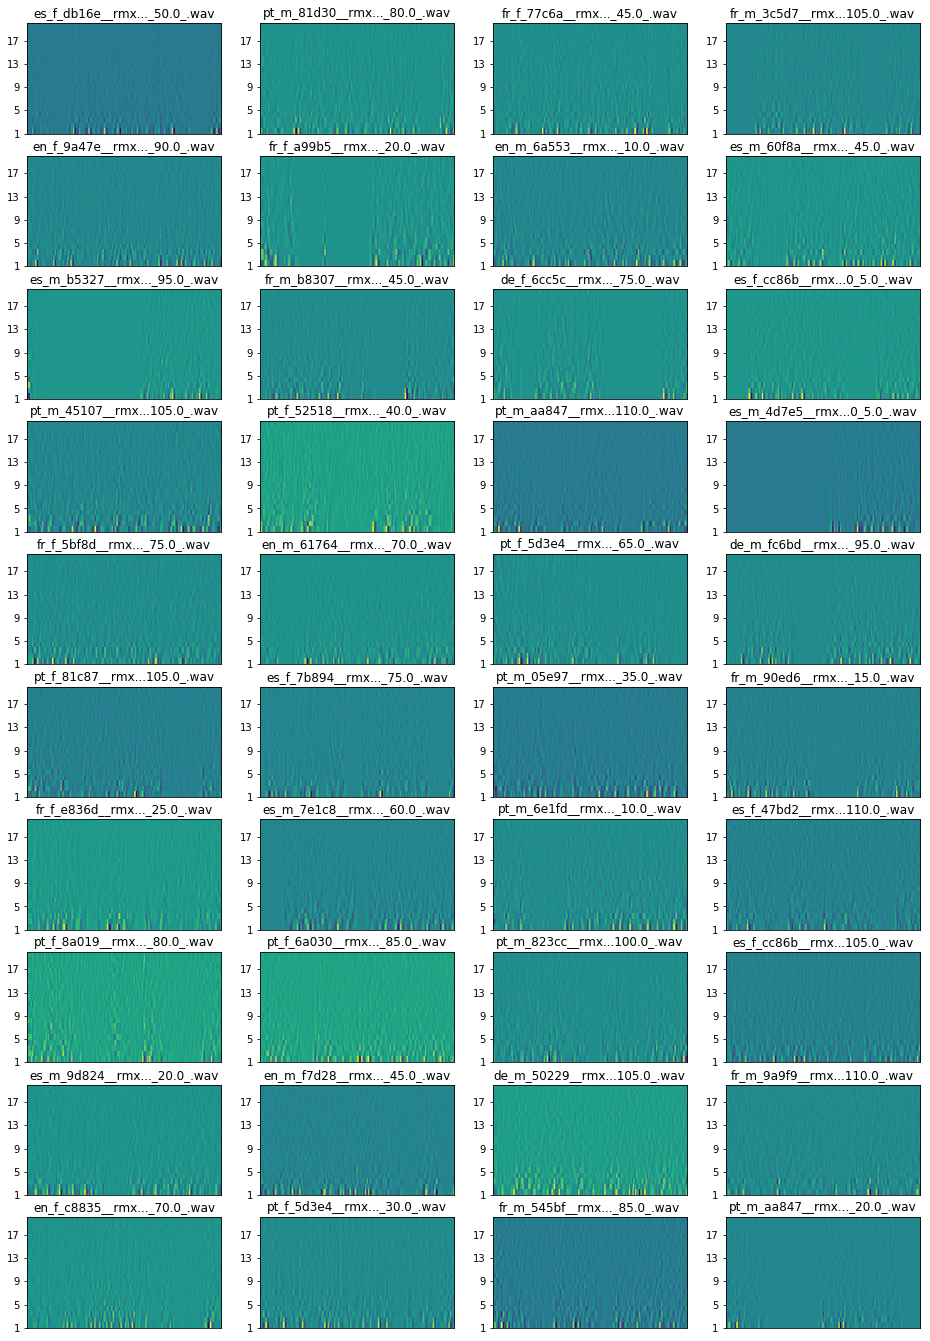

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

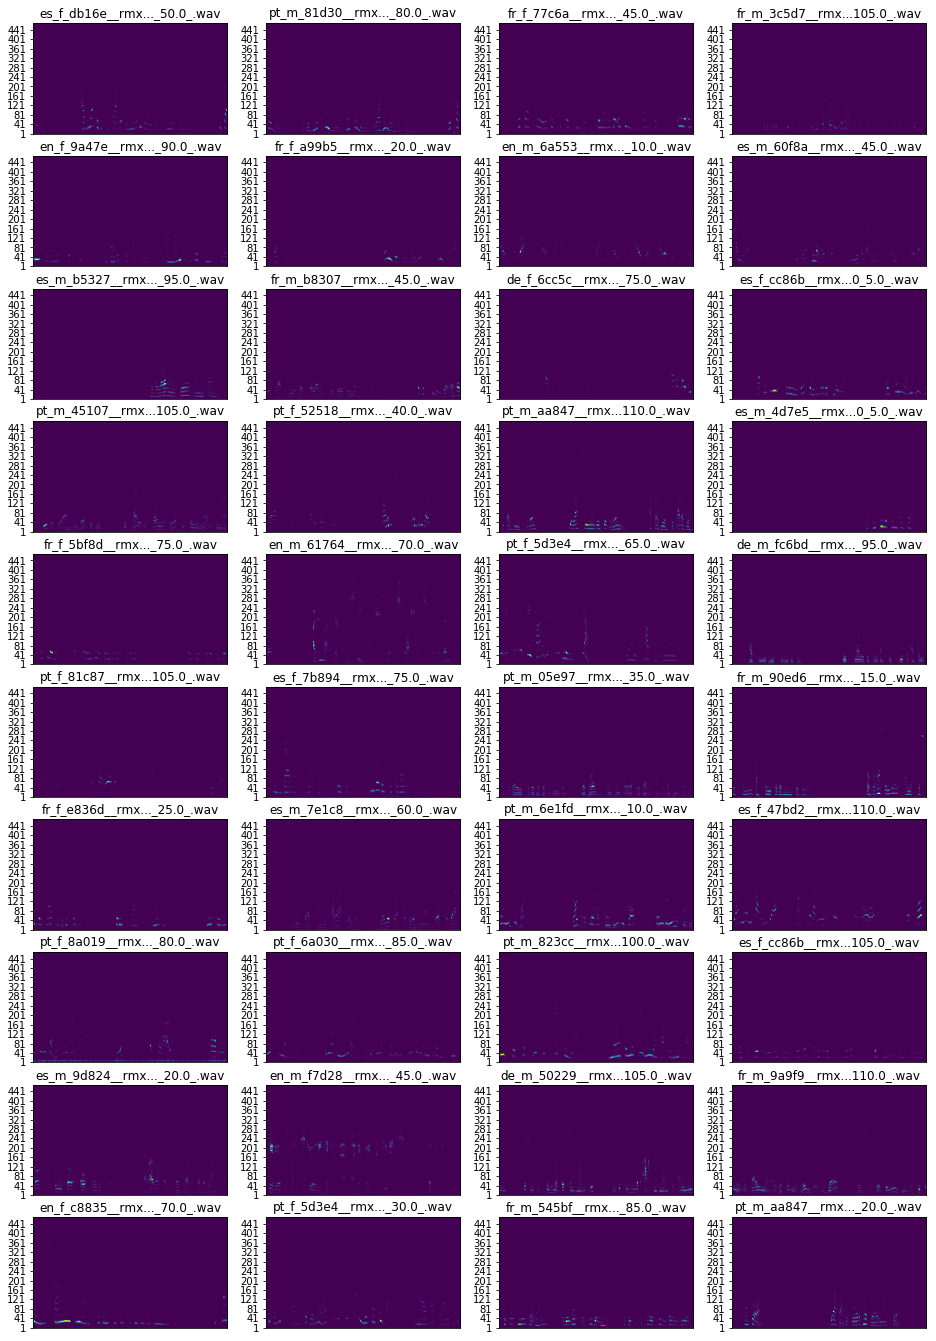

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  